Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# ResNet on CIFAR10 with Flax and JAXopt.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/deep_learning/resnet_flax.ipynb)

In this notebook, we'll go through training a deep residual network with jaxopt.

In [1]:
%%capture
%pip install jaxopt flax tqdm

In [2]:
from datetime import datetime

from functools import partial
from typing import Any, Callable, Sequence, Tuple

from flax import linen as nn

import jax
import jax.numpy as jnp
from tqdm.notebook import trange
import numpy as np

import optax
import tensorflow_datasets as tfds
import tensorflow as tf

from matplotlib import pyplot as plt

from jaxopt import loss
from jaxopt import OptaxSolver
from jaxopt import tree_util

# activate TPUs if available
try:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
except KeyError:
  print("TPU not found, continuing without it.")

tf.config.experimental.set_visible_devices([], 'GPU')

2023-02-16 11:50:30.930308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-16 11:50:30.930416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-16 11:50:30.930428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to 

TPU not found, continuing without it.


In [3]:
#@markdown Total number of epochs to train for:
MAX_EPOCH = 200 #@param{type:"integer"}
#@markdown Number of samples in each batch:
BATCH_SIZE = 128 #@param{type:"integer"}
#@markdown The initial learning rate for the optimizer:
INIT_LR = 0.05 #@param{type:"number"}
#@markdown The model architecture for the neural network. Could be either `'resnet1'`, `'resnet18'`, `'resnet34'`, `'resnet50'` or `'resnet101'`:
MODEL = "resnet34"  #@param{type:"string"}
#@markdown The dataset to use. Could be either `'cifar10'` or `'cifar100'`:
DATASET = "cifar10" #@param{type:"string"}
#@markdown The amount of L2 regularization (aka weight decay) to use:
L2_REG = 5e-4 #@param{type:"number"}

CIFAR10 and CIFAR100 are composed of 32x32 images with 3 channels (RGB). We'll now load the dataset using `tensorflow_datasets` and display a few of the first samples.

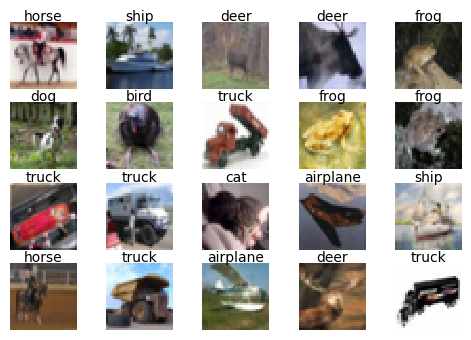

In [4]:
(raw_train_ds, raw_test_ds), info = tfds.load(DATASET, split=['train','test'], as_supervised=True, with_info=True)

input_shape = (1,) + info.features["image"].shape
num_classes = info.features["label"].num_classes
iter_per_epoch_train = info.splits['train'].num_examples // BATCH_SIZE
iter_per_epoch_test = info.splits['test'].num_examples // BATCH_SIZE

raw_train_ds_iter = iter(raw_train_ds)
_, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 4))
for i in range(4):
  for j in range(5):
    k = i * 4 + j
    image, label = next(raw_train_ds_iter)
    axes[i, j].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axes[i, j].set_axis_off()
    axes[i, j].set_title(info.features['label'].names[label], fontsize=10, y=0.9)

The accuracy of the model can be improved significantly through data augmentation. That is, instead of training on the above images, we'll generate random modifications of the images and train on those. This is done by using the `transform` argument of `tfds.load` to apply a random crop, random horizontal flip, and random color jittering.

In the next cell we show an instance of these transformations on the above images.

2023-02-16 11:50:33.041151: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


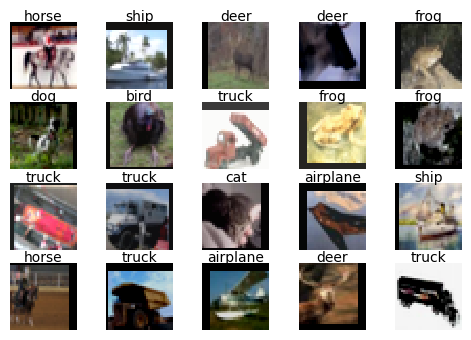

In [5]:
def augment(image, label):
  image = tf.image.resize_with_crop_or_pad(image, 40, 40)
  image = tf.image.random_crop(image, [32, 32, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_saturation(image, 0.8, 1.2)
  return image, label

raw_train_ds_iter = iter(raw_train_ds)
_, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 4))
for i in range(4):
  for j in range(5):
    k = i * 4 + j
    image, label = next(raw_train_ds_iter)
    augmented_image, _ = augment(image, label)
    axes[i, j].imshow(tf.cast(augmented_image, tf.uint8), cmap=plt.cm.gray_r, interpolation="nearest")
    axes[i, j].set_axis_off()
    axes[i, j].set_title(info.features['label'].names[label], fontsize=10, y=0.9)

Finally, on the test set, we won't be applying data augmentation to keep a reliable evaluation of the model's performance. In the test set we'll only normalize the pixels to be in the range [0, 1].

In [6]:
def normalize(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 255.0)
  return image, label

train_ds = raw_train_ds.map(augment).map(normalize)
test_ds = raw_test_ds.map(normalize)

train_ds = train_ds.shuffle(5000, reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat(2 * MAX_EPOCH).as_numpy_iterator()
test_ds = test_ds.shuffle(5000).batch(
    BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat(MAX_EPOCH).as_numpy_iterator()


NUM_CLASSES = info.features["label"].num_classes

IMG_SIZE = info.features["image"].shape

With the data ready, we can now define the model. Below we define the ResNet architecture that we'll later instantiate. We define different variants of the architecture with different sizes and depths (`'ResNet1'`, `'ResNet18'`, `'ResNet34'`, `'ResNet50'` and `'ResNet101'`). The architecture is based on the [Flax imagenet example](https://github.com/google/flax/blob/main/examples/imagenet/models.py).

In [7]:

class ResNetBlock(nn.Module):
  """ResNet block."""
  filters: int
  conv: Any
  norm: Any
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x,):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros)(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class BottleneckResNetBlock(nn.Module):
  """Bottleneck ResNet block."""
  filters: int
  conv: Any
  norm: Any
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x):
    residual = x
    y = self.conv(self.filters, (1, 1))(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), self.strides)(y)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters * 4, (1, 1))(y)
    y = self.norm(scale_init=nn.initializers.zeros)(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters * 4, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)

class ResNet(nn.Module):
  """ResNetV1."""
  stage_sizes: Sequence[int]
  block_cls: Any
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(nn.Conv, use_bias=False, dtype=self.dtype)
    norm = partial(nn.BatchNorm,
                   # use_running_average=True,
                   use_running_average=not train,
                   momentum=0.99,
                   epsilon=0.001,
                   dtype=self.dtype)

    x = conv(self.num_filters, (7, 7), (2, 2),
             padding=[(3, 3), (3, 3)],
             name='conv_init')(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(self.num_filters * 2 ** i,
                           strides=strides,
                           conv=conv,
                           norm=norm,
                           act=self.act)(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


ResNet1 = partial(ResNet, stage_sizes=[1], block_cls=ResNetBlock)
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=ResNetBlock)
ResNet50 = partial(ResNet, stage_sizes=[3, 4, 6, 3],
                   block_cls=BottleneckResNetBlock)
ResNet101 = partial(ResNet, stage_sizes=[3, 4, 23, 3],
                    block_cls=BottleneckResNetBlock)

We'll now load our train and test dataset and plot a few of the training images.

In [8]:
# Set up model.
if MODEL == "resnet1":
  net = ResNet1(num_classes=num_classes)
elif MODEL == "resnet18":
  net = ResNet18(num_classes=num_classes)
elif MODEL == "resnet34":
  net = ResNet34(num_classes=num_classes)
elif MODEL == "resnet50":
  net = ResNet50(num_classes=num_classes)
else:
  raise ValueError(f"Unknown model {MODEL}.")


def predict(params, inputs, batch_stats, train=False):
  x = inputs.astype(jnp.float32) / 255.
  all_params = {"params": params, "batch_stats": batch_stats}
  if train:
    # Returns logits and net_state (which contains the key "batch_stats").
    return net.apply(all_params, x, train=train, mutable=["batch_stats"])
  else:
    # Returns logits only.
    return net.apply(all_params, x, train=train, mutable=False), {"batch_stats": None}

logistic_loss = jax.vmap(loss.multiclass_logistic_loss)


def loss_from_logits(params, logits, labels):
  mean_loss = jnp.mean(logistic_loss(labels, logits))
  sqnorm = tree_util.tree_l2_norm(params, squared=True)
  return mean_loss + 0.5 * L2_REG * sqnorm


def _loss_accuracy(params, data, batch_stats, train=True):
  """Return loss and accuracy."""
  inputs, labels = data
  logits, net_state = predict(params, inputs, batch_stats, train=train)
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  loss = loss_from_logits(params, logits, labels)
  return loss, (accuracy, net_state["batch_stats"])

loss_accuracy = jax.jit(_loss_accuracy, static_argnums=3)

In [9]:
# Initialize solver.

shedule_fn = optax.cosine_onecycle_schedule(
    transition_steps=iter_per_epoch_train * MAX_EPOCH,
    peak_value=INIT_LR,
)

opt = optax.sgd(shedule_fn, momentum=0.9, nesterov=False)
# opt = optax.adam(shedule_fn)

# We need has_aux=True because loss_fun returns batch_stats.
solver = OptaxSolver(opt=opt, fun=loss_accuracy,
                     maxiter=MAX_EPOCH * iter_per_epoch_train, has_aux=True)

# Initialize parameters.
rng = jax.random.PRNGKey(0)
init_vars = net.init({"params": rng}, jax.random.normal(rng, input_shape, dtype=net.dtype))
params = init_vars["params"]
batch_stats = init_vars["batch_stats"]
start = datetime.now().replace(microsecond=0)

# Run training loop.
state = solver.init_state(params, next(train_ds), batch_stats)
jitted_update = jax.jit(solver.update)

Finally, we do the actual training. The next cell performs `'MAX_EPOCHS'` epochs of training. Each epoch is split into `'STEPS_PER_EPOCH'` steps. In each step, we sample a batch of `'BATCH_SIZE'` images from the training set and perform a gradient step on the loss function.

In [10]:
all_test_error = []
all_train_loss = []

for epoch in trange(MAX_EPOCH):
  train_loss = []
  for _ in range(iter_per_epoch_train):
    params, state = jitted_update(params=params,
                                  state=state,
                                  data=next(train_ds),
                                  batch_stats=batch_stats)
    batch_stats = state.aux[1]
    train_loss.append(state.value)
  all_train_loss.append(np.mean(train_loss))

  # make a pass over test set to compute test accuracy
  test_acc = []
  for _ in range(iter_per_epoch_test):
    test_acc.append(loss_accuracy(params, next(test_ds), batch_stats, train=False)[1][0])
  all_test_error.append(1 - np.mean(test_acc))

  0%|          | 0/200 [00:00<?, ?it/s]

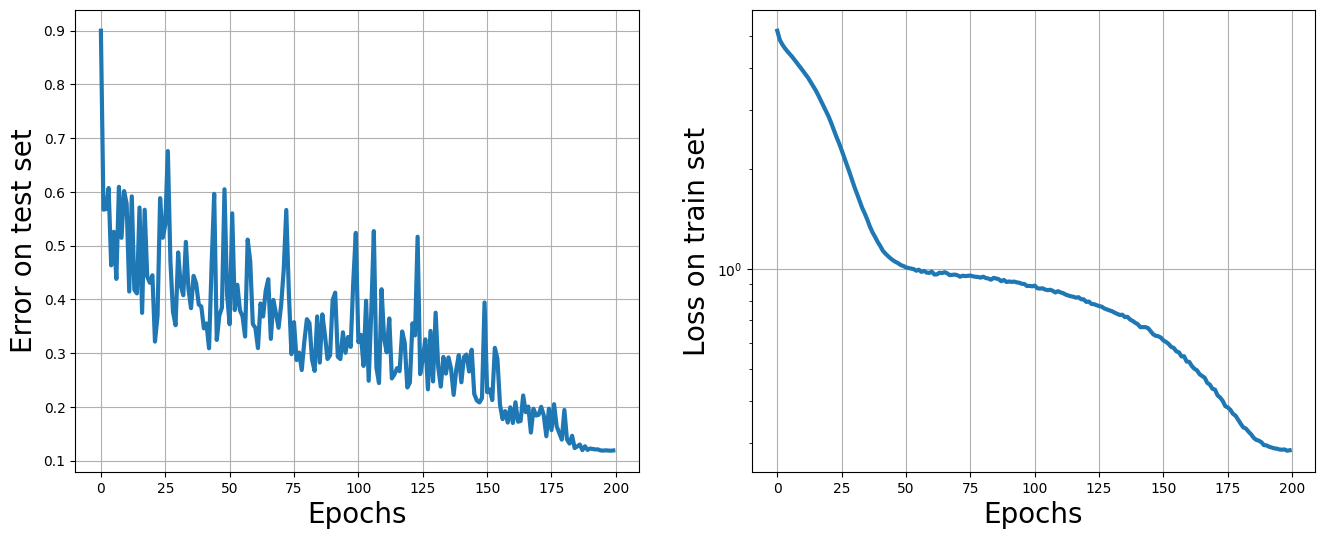

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(all_test_error, lw=3)
ax1.set_ylabel('Error on test set', fontsize=20)
ax1.grid()
ax1.set_xlabel('Epochs', fontsize=20)

ax2.plot(all_train_loss, lw=3)
ax2.set_ylabel('Loss on train set', fontsize=20)
ax2.grid()
ax2.set_xlabel('Epochs', fontsize=20)
ax2.set_yscale('log')

plt.show()

In [12]:
# Finally, let's print the test 
print('Final accuracy on test set: ', 1 - all_test_error[-1])

Final accuracy on test set:  0.8811097741127014
